In [1]:
# import os
# print("Current working directory:", os.getcwd())

## Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta


## Import Dataset

In [3]:
# Load the .dta file into a DataFrame
df = pd.read_stata("/home/jovyan/work/deposit-prediction/cleaned_data/data2.dta")
df.head(5)


,time,year,quarter,loans_re,loans_res_mort,loans_nonres,loans_constr,loans_hel,loans_multi,loans_farmland,...,loans_re_alt,loans_res_mort_alt,loans_nonres_alt,date,JPM_open,JPM_high,JPM_low,JPM_close,JPM_volume,JPM_adjusted
0,1984Q1,1984.0,1.0,17885.0,1507883.0,3373919.507,1000767.164,NaN,168659.905,82512.338,...,NaN,NaN,NaN,1984-01-01,9.763889,11.416667,9.694444,10.083333,17587800.0,2.185469
1,1984Q2,1984.0,2.0,17889.0,1570636.0,3479612.269,1045964.585,NaN,177911.496,89458.084,...,NaN,NaN,NaN,1984-04-01,10.166667,11.083333,7.833333,8.000000,26519400.0,1.774186
2,1984Q3,1984.0,3.0,17898.0,1517173.0,3520867.479,1081006.784,NaN,187877.399,95575.014,...,NaN,NaN,NaN,1984-07-01,8.000000,10.916667,7.916667,10.166667,25493700.0,2.303449
3,1984Q4,1984.0,4.0,17901.0,1573287.0,3653117.320,1106192.417,NaN,197455.190,101280.900,...,NaN,NaN,NaN,1984-10-01,9.916667,11.958333,9.083333,11.500000,36238500.0,2.652251
4,1985Q1,1985.0,1.0,17921.0,1578838.0,3666442.893,1126150.857,NaN,177238.698,136587.129,...,NaN,NaN,NaN,1985-01-01,11.416667,14.333333,11.041667,12.500000,41314500.0,2.929453


## Exploratory Data Analysis

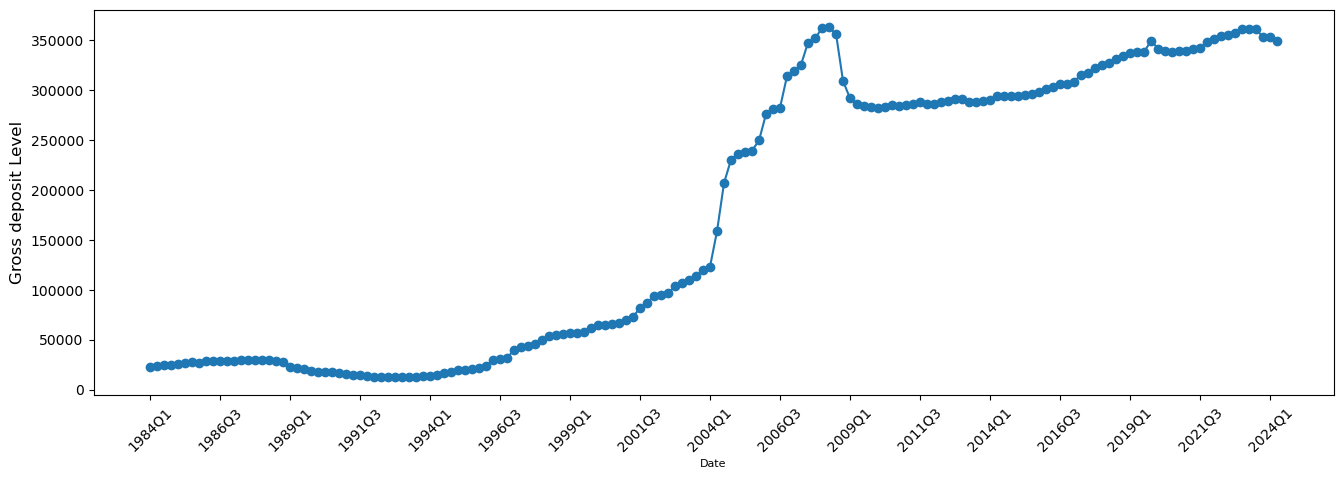

In [4]:
plt.figure(figsize=(16,5))
plt.plot(df.time, df.deposits, '-o')
plt.xticks(df.time[::10], rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Date", fontsize=8)
plt.ylabel("Gross deposit Level", fontsize=12)
plt.show()

## Stationary Analysis

### ADF Test

In [8]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

# Function to apply ADF test and return results
def adf_test(series, column_name):
    result = adfuller(series.dropna())  # Dropping NA values to avoid errors
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
    }
    return pd.DataFrame(output, index=[column_name])

# Running ADF test on the last three columns, which are related to deposits
adf_deposits = adf_test(df.deposits, "Deposit")
adf_deposits

,Test Statistic,p-value,Lags Used,Number of Observations,Critical Values
Deposit,-0.925217,0.779555,9,152,NaN


### ACF and PACF

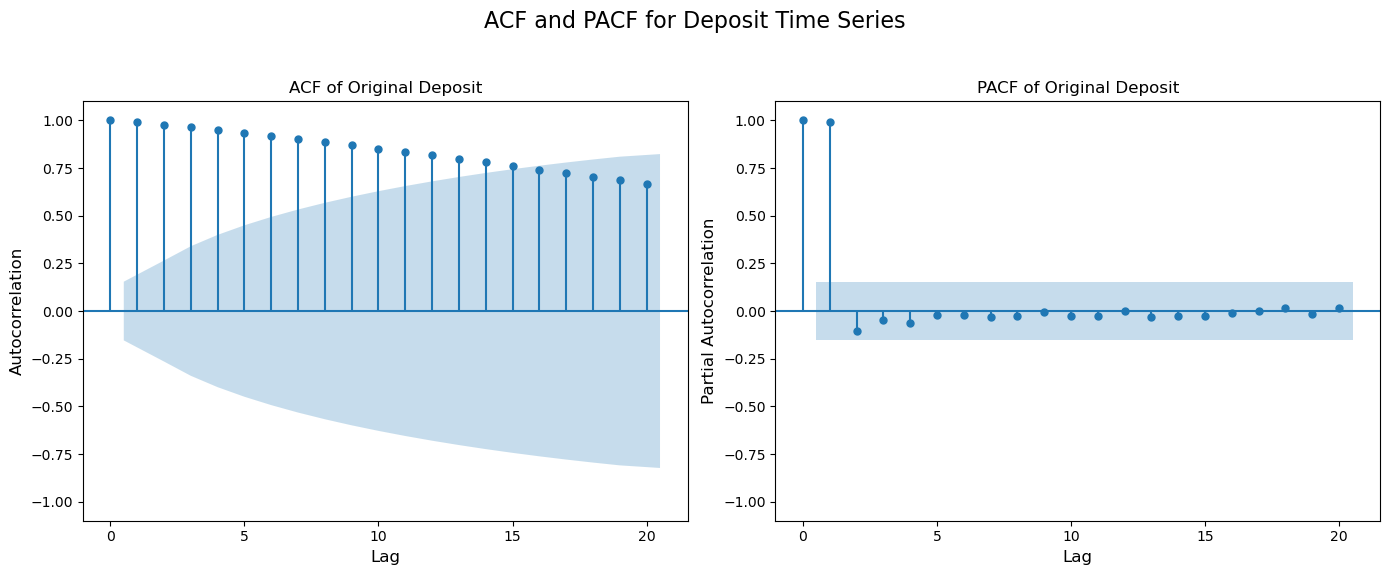

In [21]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt

# Compute ACF and PACF for the differenced series
lags = 20  # Number of lags to plot
acf_differenced = acf(df.deposits, nlags=lags, fft=True)  # Use the differenced series
pacf_differenced = pacf(df.deposits, nlags=lags)

# Plot the ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("ACF and PACF for Deposit Time Series", fontsize=16)

# ACF plot using statsmodels
sm.graphics.tsa.plot_acf(df.deposits, lags=lags, ax=axes[0], title="ACF of Original Deposit")
axes[0].set_ylabel("Autocorrelation", fontsize=12)
axes[0].set_xlabel("Lag", fontsize=12)
axes[0].set_ylim(-1.1, 1.1)

# PACF plot using statsmodels
sm.graphics.tsa.plot_pacf(df.deposits, lags=lags, ax=axes[1], title="PACF of Original Deposit")
axes[1].set_ylabel("Partial Autocorrelation", fontsize=12)
axes[1].set_xlabel("Lag", fontsize=12)
axes[1].set_ylim(-1.1, 1.1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Differencing

## Train Test Split

In [5]:
df_train = df.iloc[:-20].copy()
df_test = df.drop(df_train.index).copy()

dep_train = df['deposits'].iloc[:-20].copy()
date_train = df['time'].iloc[:-20].copy()
#tv_test = df.drop(tv_train.index).copy()
dep_test = df.drop(dep_train.index).copy()
date_test = df.drop(date_train.index).copy()


## ARIMA 

In [10]:
from statsmodels.tsa.api import ARIMA

In [12]:
!pip install pmdarima
from pmdarima import auto_arima

In [13]:
auto_arima(dep_train.values, trace=True, max_p=10, max_q=10,seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2903.758, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2943.955, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2900.200, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2904.795, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2952.219, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2901.935, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2901.752, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2903.182, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2900.926, Time=0.00 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.136 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

In [14]:
arima = auto_arima(dep_train.values, trace=True, seasonal=True, D = 1, m=1)
arima.summary()
sarima = ARIMA(dep_train.values,
                    order = (1,1,1),
                    seasonal_order = (2,1,0,36)).fit()
sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2903.758, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2943.955, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2900.200, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2904.795, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2952.219, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2901.935, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2901.752, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2903.182, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2900.926, Time=0.00 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.146 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  142
Model:             ARIMA(1, 1, 1)x(2, 1, [], 36)   Log Likelihood               -1095.391
Date:                           Fri, 15 Nov 2024   AIC                           2200.782
Time:                                   20:56:23   BIC                           2214.052
Sample:                                        0   HQIC                          2206.159
                                           - 142                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4601      0.269      1.709      0.087      -0.068       0.988
ma.L1          0.1409      0.282      0.499      0.618      -0.412       0.694
ar.S.L36      -0.9438      0.177     -5.340      0.000      -1.290      -0.597
ar.S.L72      -0.1661      0.259     -0.641      0.522      -0.674       0.342
sigma2      6.666e+07   9.25e-09   7.21e+15      0.000    6.67e+07    6.67e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               589.93
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.10
Prob(H) (two-sided):                  0.97   Kurtosis:                        14.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.19e+31. Standard errors may be unstable.
"""

In [15]:
#arima = ARIMA(dep_train.values,order=(1, 1, 0), D = 1, m=5).fit()
arima = auto_arima(dep_train.values, trace=True, seasonal=True, D = 1, m=36)
arima.summary()
sarima = ARIMA(dep_train.values,
                    order = (1,1,1),
                    seasonal_order = (2,1,0,36)).fit()
sarima.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[36]             : AIC=2225.341, Time=4.76 sec
 ARIMA(0,1,0)(0,1,0)[36]             : AIC=2299.874, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[36]             : AIC=inf, Time=2.89 sec
 ARIMA(0,1,1)(0,1,1)[36]             : AIC=2233.451, Time=0.60 sec
 ARIMA(2,1,2)(0,1,1)[36]             : AIC=2232.282, Time=3.97 sec
 ARIMA(2,1,2)(1,1,0)[36]             : AIC=2223.868, Time=4.92 sec
 ARIMA(2,1,2)(0,1,0)[36]             : AIC=2268.098, Time=0.44 sec
 ARIMA(2,1,2)(2,1,0)[36]             : AIC=2225.363, Time=6.39 sec
 ARIMA(2,1,2)(2,1,1)[36]             : AIC=2227.330, Time=10.99 sec
 ARIMA(1,1,2)(1,1,0)[36]             : AIC=2205.374, Time=5.00 sec
 ARIMA(1,1,2)(0,1,0)[36]             : AIC=2266.446, Time=0.27 sec
 ARIMA(1,1,2)(2,1,0)[36]             : AIC=2223.438, Time=5.07 sec
 ARIMA(1,1,2)(1,1,1)[36]             : AIC=2223.416, Time=3.16 sec
 ARIMA(1,1,2)(0,1,1)[36]             : AIC=2230.422, Time=1.94 sec
 ARIMA(1,1,2)(2,1,1)[36

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  142
Model:             ARIMA(1, 1, 1)x(2, 1, [], 36)   Log Likelihood               -1095.391
Date:                           Fri, 15 Nov 2024   AIC                           2200.782
Time:                                   20:58:42   BIC                           2214.052
Sample:                                        0   HQIC                          2206.159
                                           - 142                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4601      0.269      1.709      0.087      -0.068       0.988
ma.L1          0.1409      0.282      0.499      0.618      -0.412       0.694
ar.S.L36      -0.9438      0.177     -5.340      0.000      -1.290      -0.597
ar.S.L72      -0.1661      0.259     -0.641      0.522      -0.674       0.342
sigma2      6.666e+07   9.25e-09   7.21e+15      0.000    6.67e+07    6.67e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               589.93
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.10
Prob(H) (two-sided):                  0.97   Kurtosis:                        14.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.19e+31. Standard errors may be unstable.
"""

In [19]:
sarima = ARIMA(dep_train.values,
                    order = (2,0,1),
                    seasonal_order = (0,1,1,12)).fit()
sarima.summary()


/Users/sherrywang/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/sherrywang/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  142
Model:             ARIMA(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1348.919
Date:                          Fri, 15 Nov 2024   AIC                           2707.839
Time:                                  21:01:38   BIC                           2722.176
Sample:                                       0   HQIC                          2713.665
                                          - 142                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4424      0.264      5.473      0.000       0.926       1.959
ar.L2         -0.4424      0.264     -1.678      0.093      -0.959       0.074
ma.L1          0.1233      0.270      0.457      0.647      -0.405       0.652
ma.S.L12      -0.9700      0.058    -16.867      0.000      -1.083      -0.857
sigma2      5.199e+07   3.28e-09   1.58e+16      0.000     5.2e+07     5.2e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1171.19
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               3.30   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.28e+32. Standard errors may be unstable.
"""

## Model Evaluation

In [ ]:
def mase(y_train, y_test, y_preds):
    n = len(y_train)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        denom += np.abs(y_train[i+1:i+m+1] - y_train[i]*np.ones(m)).mean()
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom

In [20]:
# MASE analysis:

test_mase = mase(y_train = dep_train.values, y_test = dep_test.deposits.values, y_preds = sarima.forecast(len(date_test)))


## Results

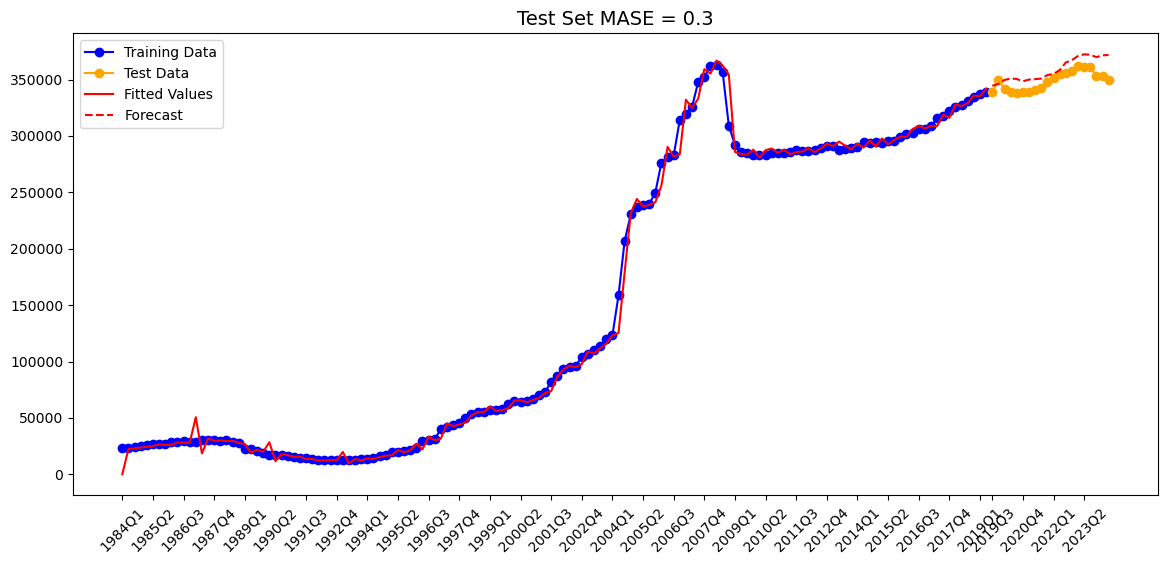

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(14,6))

# Plot training data
plt.plot(date_train,
         dep_train,
         'b-o',
         label='Training Data')

# Plot test data
plt.plot(date_test.time,
         dep_test.deposits,
         color='orange',
         marker='o',
         label='Test Data')

# Plot fitted values for training data
plt.plot(date_train,
         sarima.fittedvalues,
         'r',
         label='Fitted Values')

# Forecasting and plotting for test data
plt.plot(date_test.time,
         sarima.forecast(len(date_test)),
         '--r',
         label="Forecast")
plt.title("Test Set MASE = " + str(np.round(test_mase,3)),
             fontsize=14)
# Customize x-axis ticks to display every 10th label with rotation
xticks = np.concatenate([date_train[::5], date_test.time[::5]])

# Set combined x-ticks with rotation and font size
plt.xticks(xticks, rotation=45, fontsize=10)
plt.legend()
plt.show()







In [22]:
rolling_avg_train_preds = dep_train.rolling(12).mean()
rolling_avg_test_preds = rolling_avg_train_preds.iloc[-1] * np.ones(len(dep_test))


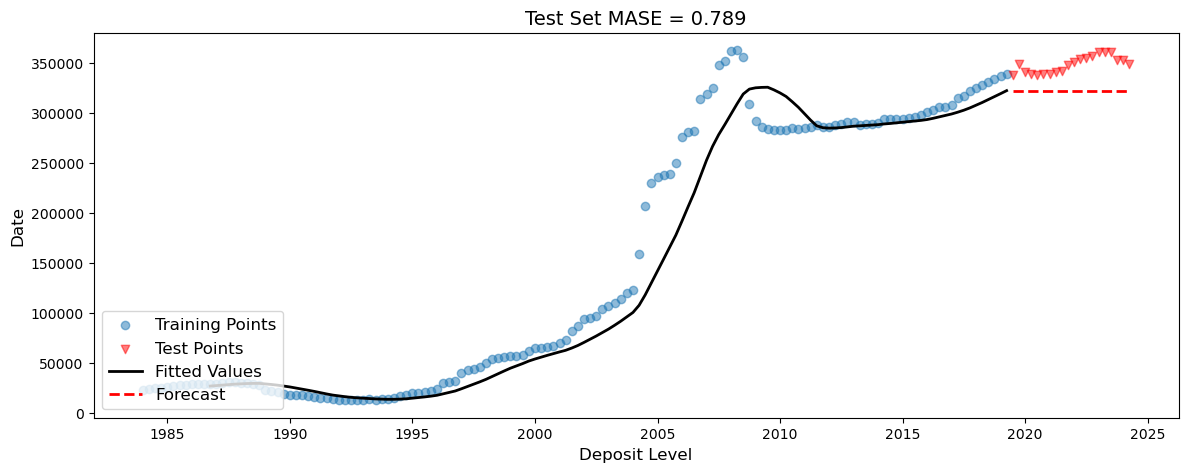

In [23]:
#baseline:
plt.figure(figsize=(14,5))
plt.scatter(df_train['date'],
              dep_train,
               alpha=.5,
               label="Training Points")

plt.scatter(date_test.date,
               dep_test.deposits,
               alpha=.5,
               c = 'red',
               marker = 'v',
               label="Test Points")

plt.plot(df_train['date'],
            rolling_avg_train_preds,
            'k-',
            linewidth = 2,
            label="Fitted Values")

plt.plot(date_test.date,
            rolling_avg_test_preds,
            'r--',
            linewidth=2,
            label="Forecast")

plt.legend(fontsize=12, loc=3)

test_mase_base = mase(y_train = dep_train, y_test = dep_test.deposits, y_preds = rolling_avg_test_preds)

plt.title("Test Set MASE = " + str(np.round(test_mase_base,3)),
             fontsize=14)

plt.xlabel("Deposit Level", fontsize=12)
plt.ylabel("Date", fontsize=12)






plt.show()

In [ ]:
#k fold cross validation
#grid search for best seasonality
